# CHAMPS Dataset Scalar Coupling

- Michael Follari
- [Predicting Molecular Properties](https://www.kaggle.com/c/champs-scalar-coupling)
- UNCG Physics 2020
- Dr. Ajay Covell

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

More plot styling can be found [here.](https://matplotlib.org/tutorials/introductory/customizing.html)

In [811]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams.update({'font.size': 16})

# Data Sets
* structures.csv - `structures_df` - Contains the xyz coordinates of each atom within each molecule
* train.csv - `train_df` - Contains the type and scalar_coupling_constant between every atoms pair within each molecule.

### The following code imports both the above datasets, merges, and adds additional columns.
* Only added column is currently displacement between the two atoms in the bond.

In [3]:
structure_path = 'D:\data\champs\zip\structures.zip'
train_path = 'D:\data\champs\zip\\train.zip'
test_path = 'D:\data\champs\zip\\test.zip'
train_bond_path = 'D:\data\champs\zip\\train_bond.gz'
test_bond_path = 'D:\data\champs\zip\\test_bond.gz'

In [4]:
# Load in Structure and Train CSV files, merge, calculate values, and save to Molecules CSV
def merge_struct_dataset(path_struct, path_train, path_merged):
    
    # load in struct and train datasets
    structures_df = pd.read_csv(path_struct)
    train_df = pd.read_csv(path_train)

    # Merge structure data onto train_df for each atom (atom_index_0 and atom_index_1). Hold in mol_df
    mol_df = train_df.merge(structures_df, left_on=['molecule_name','atom_index_0'], right_on=['molecule_name','atom_index'])
    mol_df = mol_df.merge(structures_df, left_on=['molecule_name','atom_index_1'], right_on=['molecule_name','atom_index'])

    # drop extra columns from merge and rename
    mol_df.drop(['atom_index_x','atom_index_y'], axis=1, inplace=True)
    mol_df.rename(columns={'atom_x':'atom_0','atom_y':'atom_1','x_x':'x_0','y_x':'y_0','z_x':'z_0','x_y':'x_1','y_y':'y_1','z_y':'z_1'}, inplace=True)
    
    # Save to CSV
    mol_df.to_csv(path_merged, compression="gzip")
    
# adds new columns with calculated values to molecule df
def add_all_calculations(df):
    mol_df = add_mol_displacement(df)
    mol_df = add_mol_angle(df)
    return mol_df
    
# calculates the displacement for each atom interaction 
def add_mol_displacement(df):
    df['displacement'] = df.apply(lambda row: calc_disp(row), axis=1)
    return df

# calculates the angle between the two atoms
def add_mol_angle(df):
    df['angle'] = df.apply(lambda row: calc_ang(row), axis=1)
    return df
    
    
# calculates the angle between the two atoms
def add_mol_eff(df):
    df['eff'] = df.apply(lambda row: calc_eff(df, row), axis=1)
    return df
    
    
# calculcates displacement on a passed row
def calc_disp(row):
    return np.linalg.norm(np.array([row['x_1']-row['x_0'],row['y_1']-row['y_0'],row['z_1']-row['z_0']]))

# calc angle between
def calc_ang(row):
    u = np.array([row['x_0'],row['y_0'],row['z_0']])
    v = np.array([row['x_1'],row['y_1'],row['z_1']])
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

# calc some very poor and bad estimation value of potential
def calc_eff(df, row):
    
    mol_name = row['molecule_name']
    atom_0 = row['atom_index_0']
    atom_1 = row['atom_index_1']
    
    # Get molecule structure
    molecule_df = df[df.molecule_name == mol_name]
    molecule_df_0 = molecule_df[(molecule_df.atom_index_0 == atom_0) | (molecule_df.atom_index_1 == atom_0) ]
    eff_0 = molecule_df_0.apply( lambda row : row['displacement'] * row['angle'], axis=1 ).sum()
    
    molecule_df_1 = molecule_df[(molecule_df.atom_index_0 == atom_1) | (molecule_df.atom_index_1 == atom_1) ]
    eff_1 = molecule_df_1.apply( lambda row : row['displacement'] * row['angle'], axis=1 ).sum()
    
    return eff_0 + eff_1



# Saves df to path.
def save_df(df, path):
    df.to_csv(path, compression="gzip")

### Merge strucutre data with train and test data sets.
* Only need to do once to generaete and save to dataframes as CSV files, then load as normla CSV

In [5]:
# merge_struct_dataset(structure_path, train_path, train_bond_path)
# merge_struct_dataset(structure_path, test_path, test_bond_path)

#### Load merged datasets

In [6]:
bond_df = pd.read_csv( train_bond_path )

In [7]:
bond_df

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,displacement,angle
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.807600,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,-0.901529
1,1,4,dsgdb9nsd_000001,2,0,1JHC,84.807400,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.815896
2,2,7,dsgdb9nsd_000001,3,0,1JHC,84.809300,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946,0.814618
3,3,9,dsgdb9nsd_000001,4,0,1JHC,84.809500,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948,0.815563
4,4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,-0.557883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,4659071,4659040,dsgdb9nsd_133884,13,17,3JHH,3.062820,H,2.582409,-1.260138,0.293499,H,1.126550,-1.348733,-1.933838,2.662406,0.535438
4659072,4659072,4659067,dsgdb9nsd_133884,16,17,3JHH,0.789559,H,-0.084531,1.110807,-1.796741,H,1.126550,-1.348733,-1.933838,2.744968,0.340541
4659073,4659073,4659038,dsgdb9nsd_133884,13,14,3JHH,1.005250,H,2.582409,-1.260138,0.293499,H,2.087537,1.391489,0.548687,2.709455,0.512078
4659074,4659074,4659039,dsgdb9nsd_133884,13,15,3JHH,1.005260,H,2.582409,-1.260138,0.293499,H,1.542918,0.547487,2.023550,2.709451,0.517201


In [8]:
# test_bond_df = pd.read_csv( test_bond_path )
# test_bond_df.head()

In [9]:
# test_df = pd.read_csv( test_path )
struct_df = pd.read_csv( structure_path )

In [10]:
struct_df

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
...,...,...,...,...,...,...
2358870,dsgdb9nsd_133885,11,H,-1.454004,-0.967309,1.459246
2358871,dsgdb9nsd_133885,12,H,0.277779,-2.697872,0.195770
2358872,dsgdb9nsd_133885,13,H,2.515854,-1.151784,0.527369
2358873,dsgdb9nsd_133885,14,H,0.013699,1.199431,-1.680192


### Adding new calculated columns
This is only ran once, if df is saved (as it should be to avoid re-calculating)

In [11]:
# Append new columns with calculated values
# bond_df = add_all_calculations(mol_df)

# Just adding one row, only need to do once
# bond_df = add_mol_angle(bond_df)

# bond_df = add_mol_eff(bond_df)

# Save new df
# bond_df.to_csv(train_bond_path, compression="gzip")

In [12]:
bond_df.head()

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,displacement,angle
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,-0.901529
1,1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.815896
2,2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946,0.814618
3,3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948,0.815563
4,4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,-0.557883


# Exploration
* Simple Regression of Scalar Coupling & Atom Displacement.

In [13]:
def score_type( y_test, y_calc ):
    y = list(zip(y_test, y_calc))
    error = sum( [abs(i - j) for i, j in y] )
    return np.log10( error / len(y) )

def score(types_data):
    
    total_score = 0
    for typ in types_data:
        total_score += score_type(typ)
    return total_score / len(types_data)

### The different kinds of bonds present in the data

In [14]:
bond_types = bond_df.type.unique()
print(bond_types)

['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


### Strong clustering of bonds, relationship between displacement and coupling constant
This is seen since the different bond types inhabit different spaces. Certain bonds have their own range of displacement strengths and scalar magnitudes.

Lets see if this relationship/clustering is seen for angle dependence.

#### Fetching and train/test splitting of data for regressions

In [15]:
def get_displacement_coupling(df, bond_type):
    df = df[ df.type == bond_type].sort_values(by=['displacement'])
    # Split and return into x and y arrays
    x = df['displacement'].values
    y = df['scalar_coupling_constant'].values
    return np.array([x,y])

def get_disp_ang_coupling(df, bond_type):
    df = df[ df.type == bond_type].sort_values(by=['displacement'])
    # Split and return into x and y arrays
    X = (df['displacement'].values,df['angle'].values)#np.array([list(a) for a in list(zip(df['displacement'],df['angle']))])
    y = df['scalar_coupling_constant'].values
    return [X,y]

In [16]:
def datasetScatterPlot():
    for bond in bond_types:
        bond_type = bond_types[0]
        X, y = get_disp_ang_coupling(bond_df, bond )
        plt.scatter(X[0],y)
        label_plot('Coupling Constant vs. Displacement','Displacement', 'Scalar Coupling Constant')

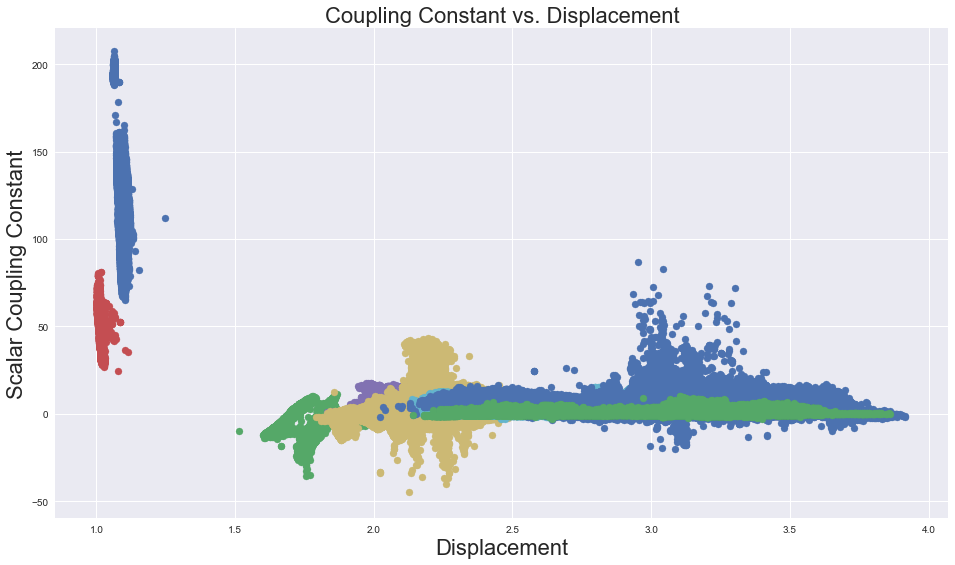

In [87]:
datasetScatterPlot()

### We will now try to use simple Machine Learning models to try and predict the coupling constant as a function of both Bond Type and Displacement.
The data will be split into their respective bond types. This is because this information is always known, we are trying to predict the coupling constant of a given bond. The information we are to work with is displacement between the two atoms that make up the bond. This information is given. The goal is to predict the coupling constant.

Since there seems to be an appreciable relationship between disoplacement and coupling constant, we can proceed with these features.

later in the notebook, an attempt to use the cosine of the angle between the bonds is explored. There is no strong relationship in that feature. Deriving more features from the data given, essentially just locations, is a challenge.

#### Plotting data points and models

In [18]:
def plot_model( x_test, y_test, y_regs, title, x_bound=[None,None], y_bound=[None,None]):
    
    xmin = x_test.min() if x_bound[0] is None else x_bound[0]
    xmax = x_test.max() if x_bound[1] is None else x_bound[1]
    ymin = y_test.min() if y_bound[0] is None else y_bound[0]
    ymax = y_test.max() if y_bound[1] is None else y_bound[1]
    
    plt.scatter(x_test,y_test, c='b')
    
    for y_reg in y_regs:
        plt.plot(x_test, y_reg, linewidth=3, linestyle='solid')
    
#     plt.xlim([xmin * 0.99,xmax * 1.01])
#     plt.ylim([ymin * 0.99,ymax* 1.01])
    plt.title(title, size=22)
    plt.xlabel('Displacement', size=22)
    plt.ylabel('Scalar Coupling Constant', size=22)
    plt.show()
    

def label_plot(title,xlabel,ylabel):
    plt.title(title, size=22)
    plt.xlabel(xlabel, size=22)
    plt.ylabel(ylabel, size=22)


# Linear Regression
- [scikit Learn Linear Regression](https://scikit-learn.org/stable/modules/linear_model.html)

In [19]:
def linear_regression(x_train, y_train, x_test):
    # Train linear regression model
    linear_reg = train_linear_regression(x_train, y_train)
    
    # Use linear regression to generate y value
    return np.array(line_data_points(x_test,linear_reg.coef_, linear_reg.intercept_)).T[0]
    
def train_linear_regression(x,y):
    # Linear Regression fit
    reg = linear_model.LinearRegression()
    reg.fit( x.reshape(-1,1), y )
    return reg

def line_data_points(x_array, coef, intercept):
    return [line_func(x, coef, intercept) for x in x_array]

def line_func(x, coef, intercept):
    return x*coef + intercept

# Random Forest Regression
* [scikit Learn Random Forest Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [20]:
def random_forest(x_train, y_train, x_test):
    # Train Random Forest regression model
    random_forest_reg = train_rand_forest(x_train, y_train)
    
    # Use Random Forest regression to generate y values
    return random_forest_reg.predict(x_test.reshape(-1,1))

def train_rand_forest(x, y):
    # Train Random Forest
    reg = RandomForestRegressor(max_depth=2, random_state=0)
    reg.fit(x.reshape(-1,1), y)
    return reg

### Trains models for data

In [21]:
def evaluate_models(plot=False):

    title = "Regression of Scalar-Coupling-Constant vs. Bond Displacement : "
    
#     fig = plt.figure()
#     ax = fig.add_subplot(10)
    
    sum_score = 0;
    for bond_type in bond_types:

        # Get x y test/train. Displacement and Bond strength
        x, y = get_displacement_coupling(bond_df, bond_type )
                
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=433)
        x_test.sort() # Sort training values (mostly for plotting)

        # Train and predict Linear regression
        y_linear_regression = linear_regression(x_train, y_train, x_test)

        # Train and predict Random Forest
        y_random_forest_regression = random_forest(x_train, y_train, x_test)

        # Calculate score for regression on type
        linear_score = score_type( y_test, y_linear_regression) 
        forest_score = score_type( y_test, y_random_forest_regression) 

        # Print result
        print(bond_type + ' has score :     Linear: ', round(linear_score, 5), '     Forest: ', round(forest_score,5 ))
        
        # Plot only if desired
        if plot:
            y_regs = [y_linear_regression, y_random_forest_regression]
            plot_model(x_test, y_test, y_regs, title+bond_type,[x_train.min(),x_train.max()], [y_train.min(),y_train.max()])

### Performance of models

In [22]:
# evaluate_models(False)

### Graphs of the models

1JHC has score :     Linear:  1.1961      Forest:  1.18678


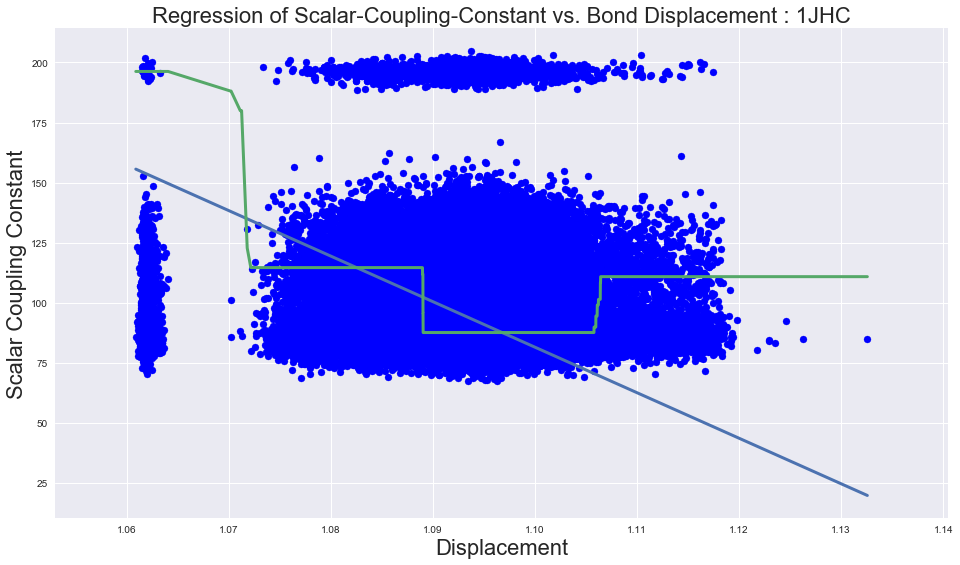

2JHH has score :     Linear:  0.4919      Forest:  0.51331


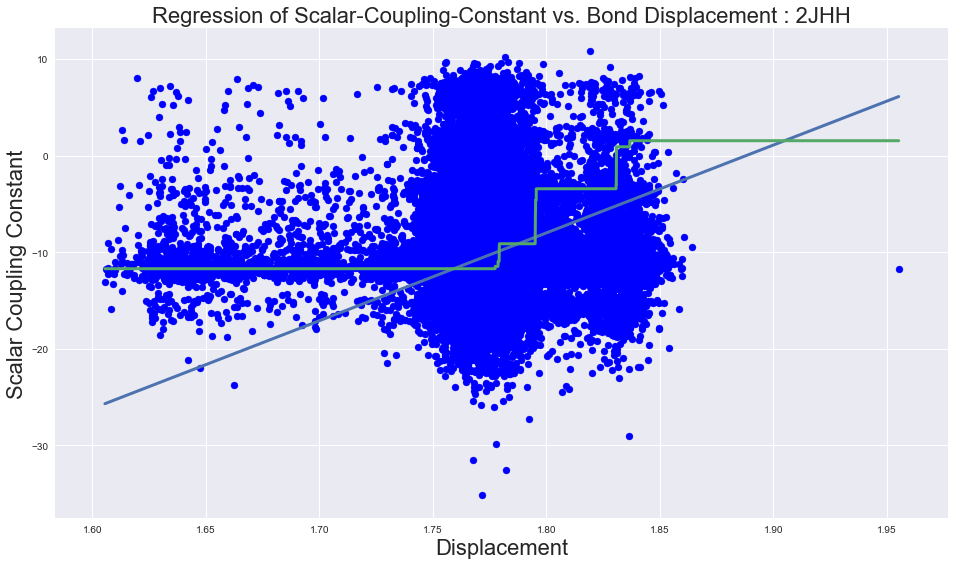

1JHN has score :     Linear:  1.06086      Forest:  1.07067


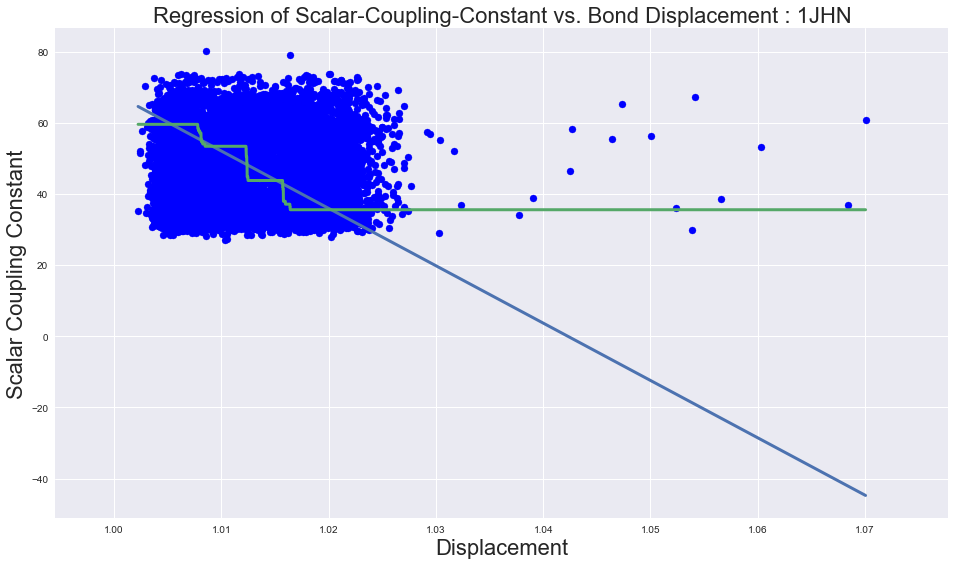

2JHN has score :     Linear:  0.47403      Forest:  0.49034


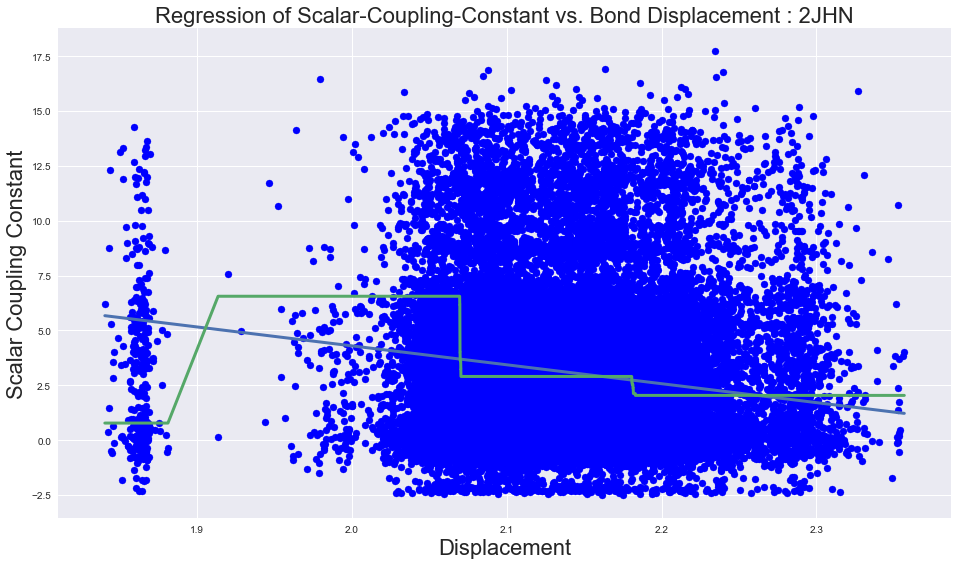

2JHC has score :     Linear:  0.46985      Forest:  0.48742


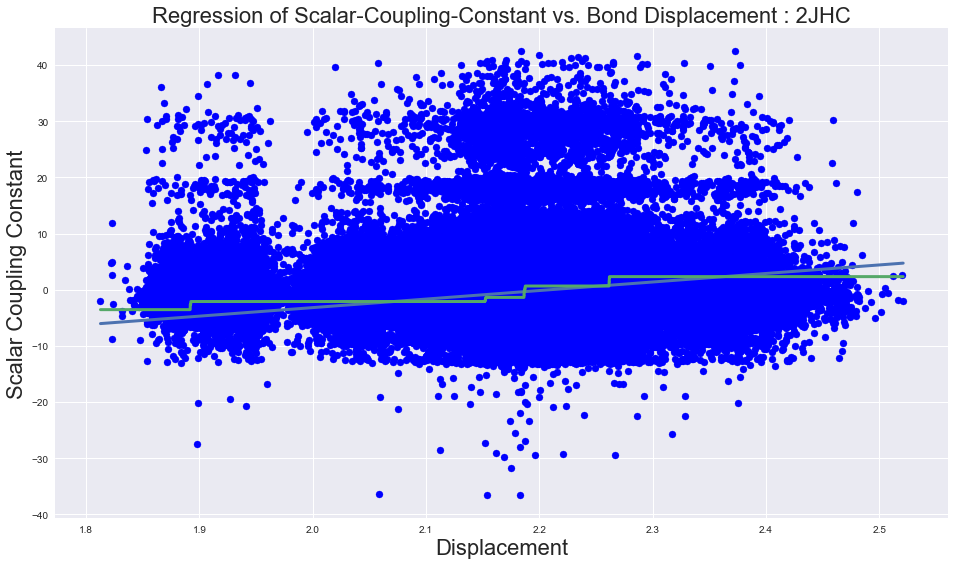

3JHH has score :     Linear:  0.49747      Forest:  0.53898


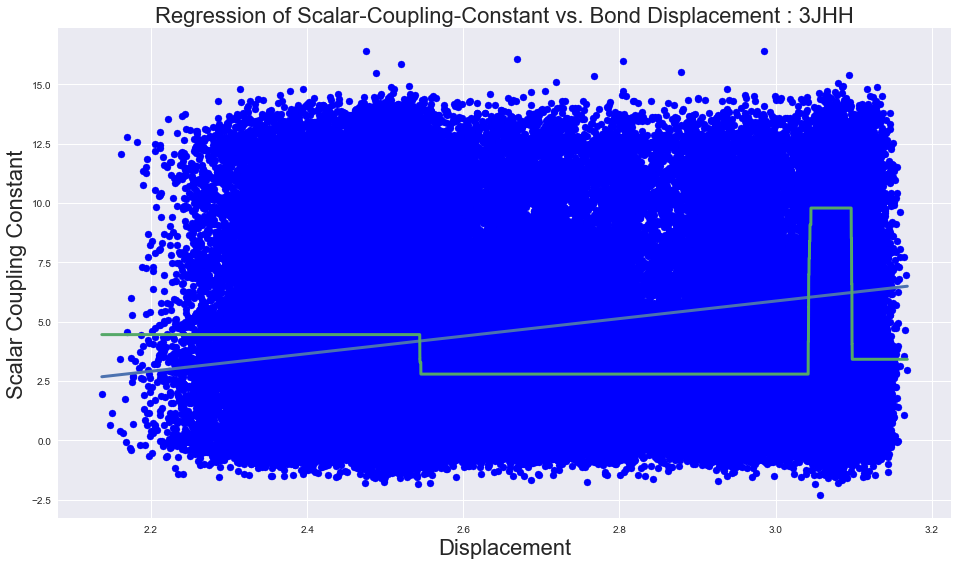

3JHC has score :     Linear:  0.41158      Forest:  0.42091


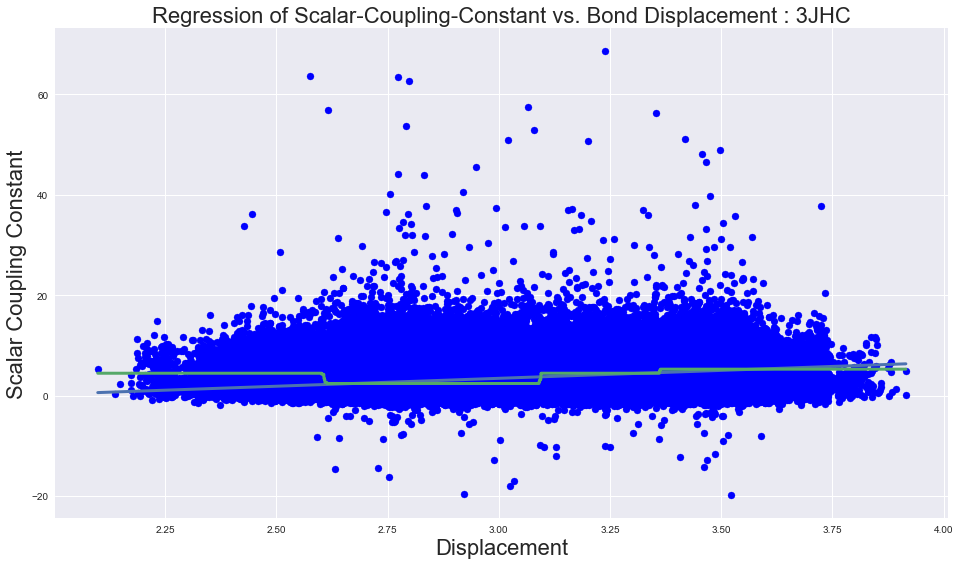

3JHN has score :     Linear:  0.0032      Forest:  0.0161


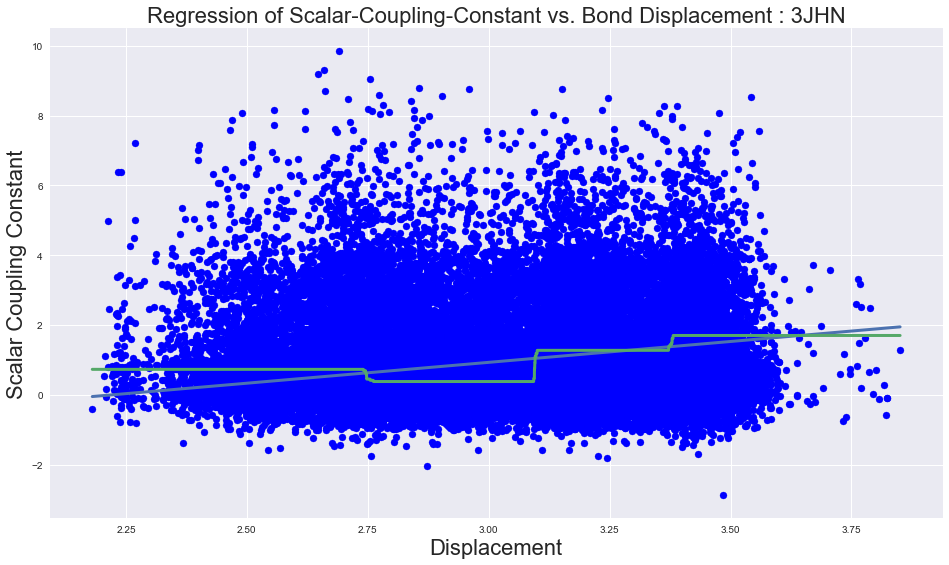

In [88]:
evaluate_models(True)

# Cosine of Angle Exploration

### No relationship between cosine of angle and coupling constant
This is seen as every bond type is spread across the entire angle cos() range, -1 to 1

In [24]:
def cosineDatasetScatterPlot():
    for bond in bond_types:
        bond_type = bond_types[0]
        X, y = get_disp_ang_coupling(bond_df, bond )
        plt.scatter(X[1],y)
        label_plot('Coupling Constant vs. Cosine of Angle','Cos(theta)', 'Scalar Coupling Constant')

In [25]:
# cosineDatasetScatterPlot()

### No relationship between displacement and cosine of angle between atoms.
This is seen since for a given displacement, the  range of cosine values is from -1 to 1, full range.

In [26]:
def cosDispDatasetScatterPlot():
    for bond in bond_types:
        bond_type = bond_types[0]
        X, y = get_disp_ang_coupling(bond_df, bond )
        plt.scatter(X[0],X[1])
        label_plot('Displacement vs. Cosine of Angle','Displacement', 'Cos(theta)')

In [27]:
# cosDispDatasetScatterPlot()

# Clustering
Since we only have one usedul dimension, displacement, as of now, clustering is not possible.

In [28]:
# from sklearn.datasets.samples_generator import make_blobs
# XX, yy = make_blobs(n_samples=300, centers=4,
#                   random_state=0, cluster_std=0.60)
# plt.scatter(XX[:, 0], XX[:, 1], s=50);

In [29]:
# est = KMeans(4)  # 4 clusters
# est.fit(XX)
# y_kmeans = est.predict(XX)
# plt.scatter(XX[:, 0], XX[:, 1], c=y_kmeans, s=50, cmap='rainbow');

In [30]:
from sklearn.cluster import KMeans
from sklearn import cluster

bond_type = bond_types[0]
x, y = get_displacement_coupling(bond_df, bond_type )
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=433)
x_test.sort() # Sort training values (mostly for plotting)

X_train = np.array([list(a) for a in list(zip(x_train,y_train))])
X_test = np.array([list(a) for a in list(zip(x_test,y_test))])

In [31]:
num_clusters = 4;

### KMeans Clustering

In [32]:
est = KMeans(num_clusters)
est.fit(X_train)
y_kmeans = est.predict(X_test)

### Spectral Clustering

In [33]:
# spectral = cluster.SpectralClustering(
#         n_clusters=num_clusters, eigen_solver='arpack',
#         affinity="nearest_neighbors")
    
# spectral.fit(X_train)
# y_spectral = spectral.predict(X_test)

### Agglomerative Clusrtering

In [34]:
# ward = cluster.AgglomerativeClustering(
#         n_clusters=num_clusters, linkage='ward')
# ward.fit(X_train)
# y_ward = ward.predict(X_test)

### This result does not mean anything. We only have one feature.
It's just useless, look at it

In [35]:
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_kmeans, s=50, cmap='rainbow');

### Adding feature to extract entire molecule from each 

Calculate the potential well that every atom is in. This could help us how?

In [36]:
bond_df

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,displacement,angle
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.807600,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,-0.901529
1,1,4,dsgdb9nsd_000001,2,0,1JHC,84.807400,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.815896
2,2,7,dsgdb9nsd_000001,3,0,1JHC,84.809300,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946,0.814618
3,3,9,dsgdb9nsd_000001,4,0,1JHC,84.809500,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948,0.815563
4,4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,-0.557883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,4659071,4659040,dsgdb9nsd_133884,13,17,3JHH,3.062820,H,2.582409,-1.260138,0.293499,H,1.126550,-1.348733,-1.933838,2.662406,0.535438
4659072,4659072,4659067,dsgdb9nsd_133884,16,17,3JHH,0.789559,H,-0.084531,1.110807,-1.796741,H,1.126550,-1.348733,-1.933838,2.744968,0.340541
4659073,4659073,4659038,dsgdb9nsd_133884,13,14,3JHH,1.005250,H,2.582409,-1.260138,0.293499,H,2.087537,1.391489,0.548687,2.709455,0.512078
4659074,4659074,4659039,dsgdb9nsd_133884,13,15,3JHH,1.005260,H,2.582409,-1.260138,0.293499,H,1.542918,0.547487,2.023550,2.709451,0.517201


In [37]:
bond_df[bond_df.molecule_name == 'dsgdb9nsd_000001']
# bond_df[bond_df.type == bond_types[0]].head(100)

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,displacement,angle
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,-0.901529
1,1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.815896
2,2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946,0.814618
3,3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948,0.815563
4,4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,-0.557883
5,5,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,-0.976519
6,6,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,H,1.011731,1.463751,0.000277,H,-0.540815,1.447527,-0.876644,1.783158,0.497089
7,7,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,-0.671855
8,8,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,H,1.011731,1.463751,0.000277,H,-0.523814,1.437933,0.906397,1.783148,0.497671
9,9,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543,H,-0.540815,1.447527,-0.876644,H,-0.523814,1.437933,0.906397,1.783148,0.496889


In [38]:
struct_df

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
...,...,...,...,...,...,...
2358870,dsgdb9nsd_133885,11,H,-1.454004,-0.967309,1.459246
2358871,dsgdb9nsd_133885,12,H,0.277779,-2.697872,0.195770
2358872,dsgdb9nsd_133885,13,H,2.515854,-1.151784,0.527369
2358873,dsgdb9nsd_133885,14,H,0.013699,1.199431,-1.680192


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<small><small><small>This holds space so I can scroll further</small></small></small>

# XGBoost

In [39]:
bond_type = bond_types[0]
x, y = get_displacement_coupling(bond_df, bond_type )
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=433)
x_test.sort() # Sort training values (mostly for plotting)

X_train = np.array([list(a) for a in list(zip(x_train,y_train))])
X_test = np.array([list(a) for a in list(zip(x_test,y_test))])

In [40]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(X_train, label=[1]*531849 )
dtest = xgb.DMatrix(X_test)
# specify parameters via map
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
num_round = 10
bst = xgb.train(param, dtrain)
# make prediction
preds = bst.predict(dtest)

In [41]:
preds

array([0.99998534, 0.99998534, 0.99998534, ..., 0.99998534, 0.99998534,
       0.99998534], dtype=float32)

In [42]:
# get_displacement_coupling(bond_df,bond_type)[0][:177284]
X_test

array([[  1.06090143,  85.5185    ],
       [  1.06104129, 123.132     ],
       [  1.06104278,  92.0921    ],
       ...,
       [  1.12461524,  92.3369    ],
       [  1.12629588,  84.8682    ],
       [  1.13256468,  84.6946    ]])

In [43]:
preds

array([0.99998534, 0.99998534, 0.99998534, ..., 0.99998534, 0.99998534,
       0.99998534], dtype=float32)

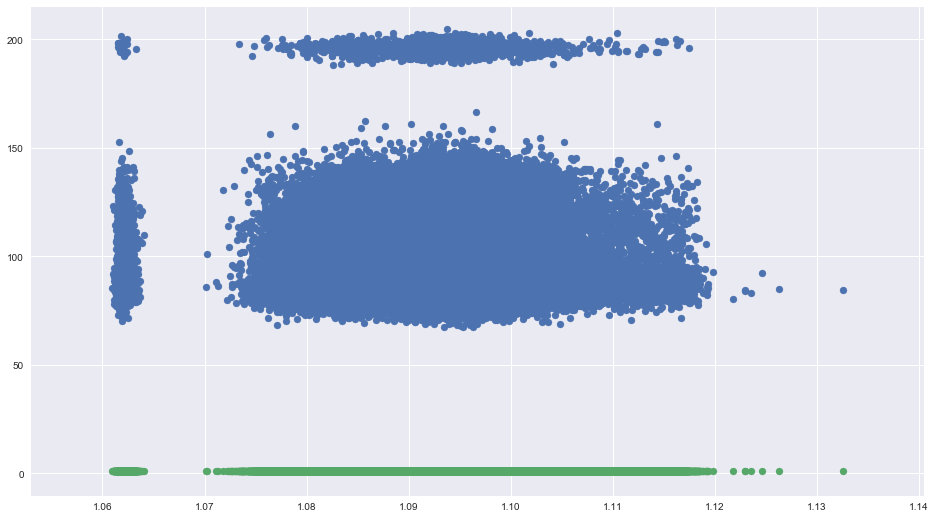

In [44]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, preds)

# Neural Network
I am utilizing TensorFlow, as it is specialized and allows GPU support -- which should greatly speed up whataever I do.

I have working FFNN working. I would like to prevent overfitting. So, I will use the minimal amount of neurons that makes sense to me.

The NN input layer is fed the follwing information:
* Type (8 neurons)
* atom 1 and 2 x,y,z (6 neurons)
* displacement (1 neuron)

From this, I would like the NN to classify which Sub-species it has, using Type and XYZ / Displacement. There are at most 8 (rough estimate) sub species for any given bond type. This

I will look at each of the bond types.

In [ ]:
A

In [45]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

In [46]:
bond_df

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,displacement,angle
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.807600,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,-0.901529
1,1,4,dsgdb9nsd_000001,2,0,1JHC,84.807400,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.815896
2,2,7,dsgdb9nsd_000001,3,0,1JHC,84.809300,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946,0.814618
3,3,9,dsgdb9nsd_000001,4,0,1JHC,84.809500,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948,0.815563
4,4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,-0.557883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,4659071,4659040,dsgdb9nsd_133884,13,17,3JHH,3.062820,H,2.582409,-1.260138,0.293499,H,1.126550,-1.348733,-1.933838,2.662406,0.535438
4659072,4659072,4659067,dsgdb9nsd_133884,16,17,3JHH,0.789559,H,-0.084531,1.110807,-1.796741,H,1.126550,-1.348733,-1.933838,2.744968,0.340541
4659073,4659073,4659038,dsgdb9nsd_133884,13,14,3JHH,1.005250,H,2.582409,-1.260138,0.293499,H,2.087537,1.391489,0.548687,2.709455,0.512078
4659074,4659074,4659039,dsgdb9nsd_133884,13,15,3JHH,1.005260,H,2.582409,-1.260138,0.293499,H,1.542918,0.547487,2.023550,2.709451,0.517201


In [47]:
def get_dataset():
    # get sample of bond_df
    dataset = bond_df.sample(frac=0.1,random_state=0)
    
    # split data into categorical and feature
    ds_categ = pd.get_dummies(dataset[['type']], prefix='', prefix_sep='')
    ds_categ_col = ds_categ.columns
    ds_label_col = 'scalar_coupling_constant'
    
    # remove other columns to get numerical
    ds_numer = dataset.reset_index(drop=True)
    dataset_dropcols = ['id','molecule_name','atom_index_0','type','atom_0','atom_1','atom_index_1','angle']
    ds_numer = ds_numer.drop(columns=dataset_dropcols)
    ds_numer_col = ds_numer.columns
    ds = ds_numer.merge(ds_categ, right_index=True,left_index=True)
    
    return (ds, ds_numer_col, ds_categ_col,ds_label_col)
    

In [48]:
(ds, ds_num, ds_cat, ds_label) = get_dataset()

In [49]:
ds

,Unnamed: 0,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,displacement,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
1,2638411,0.212866,1.371728,-0.731565,-1.710550,-0.636943,-1.780926,-0.935044,2.395272,1,0,0,0,0,0,0,0
11,2824414,-4.180950,-3.546972,2.185661,0.022598,-1.819948,2.170805,0.591937,1.818511,0,1,0,0,0,0,0,0
25,1948308,80.534600,0.377243,-0.163392,-0.897748,-0.092984,0.196055,0.029221,1.099812,0,0,1,0,0,0,0,0
43,1139992,6.439640,-0.898924,-1.109252,1.461525,1.153947,0.935879,0.038302,3.228375,0,0,0,0,0,0,1,0
64,3780077,83.866600,-0.630108,1.943396,0.878559,-0.010226,1.603082,0.043572,1.094198,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465851,3708884,9.314820,-4.452242,-0.235085,0.351155,-1.413055,-0.553779,-0.044248,3.081325,0,0,0,1,0,0,0,0
465865,267904,-0.523726,0.346055,0.464058,2.905183,0.053400,0.157682,-0.012222,2.948010,1,0,0,0,0,0,0,0
465887,3619761,9.471340,0.817685,1.320367,-2.573945,0.814283,-1.965275,-1.467478,3.466947,0,0,0,0,1,0,0,0
465895,3783611,4.431980,-4.357712,-1.338441,-1.270210,-1.793796,-2.101006,-0.025918,2.950158,0,0,0,0,0,0,1,0


In [50]:
ds_stats = ds[ds_num].describe().transpose()
ds_stats

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,46660.0,2.334839e+06,1.349258e+06,102.000000,1.164767e+06,2.349745e+06,3.501274e+06,4.659037e+06
scalar_coupling_constant,46660.0,1.589514e+01,3.496717e+01,-29.389600,-2.496923e-01,2.256620e+00,7.399510e+00,2.014730e+02
x_0,46660.0,1.044471e-01,1.756679e+00,-7.032909,-9.522882e-01,1.322366e-01,1.230162e+00,7.034801e+00
y_0,46660.0,-2.247350e-01,2.110861e+00,-7.491826,-1.840932e+00,-3.004691e-01,1.752830e+00,9.392650e+00
z_0,46660.0,5.624465e-02,1.561160e+00,-6.510330,-9.556633e-01,1.011557e-02,1.037177e+00,7.637578e+00
x_1,46660.0,9.672415e-02,1.476864e+00,-6.635339,-7.986005e-01,4.657118e-02,9.814830e-01,6.230948e+00
y_1,46660.0,-3.935241e-01,1.751172e+00,-7.601516,-1.580206e+00,-5.047968e-01,2.540073e-01,8.484809e+00
z_1,46660.0,8.841200e-02,1.257148e+00,-6.793899,-6.459068e-01,1.596880e-02,9.072339e-01,7.166283e+00
displacement,46660.0,2.360934e+00,7.360569e-01,1.003370,1.946040e+00,2.316136e+00,2.944435e+00,3.781588e+00


In [84]:
def train_test_norm( dataset, numer_cols, frac=0.8 ):
    train = dataset.sample(frac=frac,random_state=0) # take frac of dataset for training
    test = dataset.drop(train.index) # remove teh training set from original set, to get test sample
    
    # norm values
    train[numer_cols] = train[numer_cols].apply(norm,axis=1)
    test[numer_cols] = test[numer_cols].apply(norm,axis=1)
    return (train, test)

def norm(x):
    return (x - ds_stats['mean']) / ds_stats['std']

def unnorm_value(x, label):
    return (x * ds_stats['std'][label]) + ds_stats['mean'][label]

In [52]:
(train_ds, test_ds) = train_test_norm(ds, numer_cols=ds_num)
train_labels_data = train_ds.pop(ds_label)
test_labels_data = test_ds.pop(ds_label)
train_labels = train_labels_data.values.reshape(-1,1)
test_labels = test_labels_data.values.reshape(-1,1)

In [53]:
train_ds

,Unnamed: 0,x_0,y_0,z_0,x_1,y_1,z_1,displacement,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
444784,0.259102,1.458090,-0.224223,1.311981,0.046211,-0.758230,1.431093,0.475345,0,0,0,0,0,0,1,0
328755,-0.377032,0.025493,-0.717010,-0.801179,-0.216836,0.077150,-1.727153,-0.808573,1,0,0,0,0,0,0,0
380927,-1.074125,0.399693,0.504612,1.977937,0.259520,0.039083,1.026221,-0.299268,0,0,0,0,0,1,0,0
409031,-1.225678,-0.790847,0.840604,-0.003585,0.014251,0.181854,-0.013389,-0.291337,0,0,0,0,0,1,0,0
238177,-1.103272,-0.082929,1.019314,-0.661452,-0.043305,1.097194,-0.039642,-1.722471,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109892,-0.406525,0.049612,-0.606344,3.557303,0.512624,-0.303419,2.769582,-0.189595,1,0,0,0,0,0,0,0
99771,1.457667,1.743103,-1.326863,0.107383,1.538652,-0.931458,-1.301556,-0.238267,0,1,0,0,0,0,0,0
261561,0.825609,-0.642515,0.949241,0.380769,-0.748609,-0.037550,-0.463449,0.208129,0,0,0,1,0,0,0,0
12869,0.993557,0.597281,1.036018,-2.085065,0.477407,0.240734,-1.950473,-0.305667,0,0,0,0,0,0,1,0


In [54]:
test_ds

,Unnamed: 0,x_0,y_0,z_0,x_1,y_1,z_1,displacement,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
109,1.034590,0.272373,-0.882055,-0.575299,0.558280,-0.521084,-0.202206,-1.731178,1,0,0,0,0,0,0,0
120,-1.510266,-1.813539,-0.034008,-0.980214,-0.089945,0.261827,0.041123,1.500641,1,0,0,0,0,0,0,0
129,1.621251,0.576102,0.990384,-0.035252,-0.068596,0.226552,-0.068024,-0.254015,1,0,0,0,0,0,0,0
158,-0.033566,-0.100668,1.080586,-0.259075,-0.390195,1.115819,0.968766,-0.796688,0,0,1,0,0,0,0,0
220,-0.036560,0.049408,1.013591,0.580442,-0.601613,-0.156499,0.698852,0.546475,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465556,-0.378046,0.246241,-0.101838,1.281420,-0.075960,0.261653,-0.037863,-0.286222,0,0,0,0,0,1,0,0
465610,0.881577,1.494240,-1.869390,0.006217,0.885878,-1.300660,-2.036102,1.182179,0,0,1,0,0,0,0,0
465700,-0.280806,-0.823942,0.703578,-0.655255,0.422359,-0.078235,-1.136755,0.539098,0,0,0,0,0,0,1,0
465738,-1.254270,0.276689,-0.108722,-1.419596,0.779497,-0.905451,0.607422,1.465237,0,0,1,0,0,0,0,0


In [229]:
def build_model():
    model = keras.Sequential([
    layers.Dense(32, activation='sigmoid', input_shape=[len(train_ds.keys())]),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1)
    ])

#     optimizer = tf.keras.optimizers.RMSprop(0.01)
    optimizer = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [230]:
model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [204]:
example_batch = train_ds[:10]
example_result = model.predict(np.array(example_batch))
example_result

array([[-0.18325524],
       [ 0.4151399 ],
       [ 0.10086681],
       [ 0.0553929 ],
       [ 0.75929224],
       [-0.50305426],
       [ 0.08788782],
       [-0.40024406],
       [-0.39556915],
       [ 0.03024306]], dtype=float32)

In [234]:
EPOCHS = 10

history = model.fit(
  np.array(train_ds), np.array(train_labels),
  epochs=EPOCHS, validation_split = 0.2, verbose=0, use_multiprocessing=False)
# callbacks=[tfdocs.modeling.EpochDots()]

In [235]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.095414,0.174817,0.095414,0.094676,0.171818,0.094676,0
1,0.090408,0.168341,0.090408,0.089714,0.164199,0.089714,1
2,0.087148,0.162487,0.087148,0.087359,0.159633,0.087359,2
3,0.084518,0.157849,0.084518,0.085415,0.156538,0.085415,3
4,0.082358,0.152465,0.082358,0.082590,0.149564,0.082590,4
5,0.080025,0.147378,0.080025,0.081065,0.145454,0.081064,5
6,0.078234,0.142760,0.078234,0.079962,0.146047,0.079962,6
7,0.076764,0.139241,0.076764,0.078463,0.139680,0.078463,7
8,0.075787,0.137066,0.075787,0.077349,0.138386,0.077349,8
9,0.074793,0.135161,0.074793,0.076022,0.133389,0.076022,9


In [226]:
example_result = model.predict(np.array(test_ds))
diff_result = example_result - test_labels
diff_result.std()

0.2712004806033214

In [185]:
# plt.plot(diff_result)

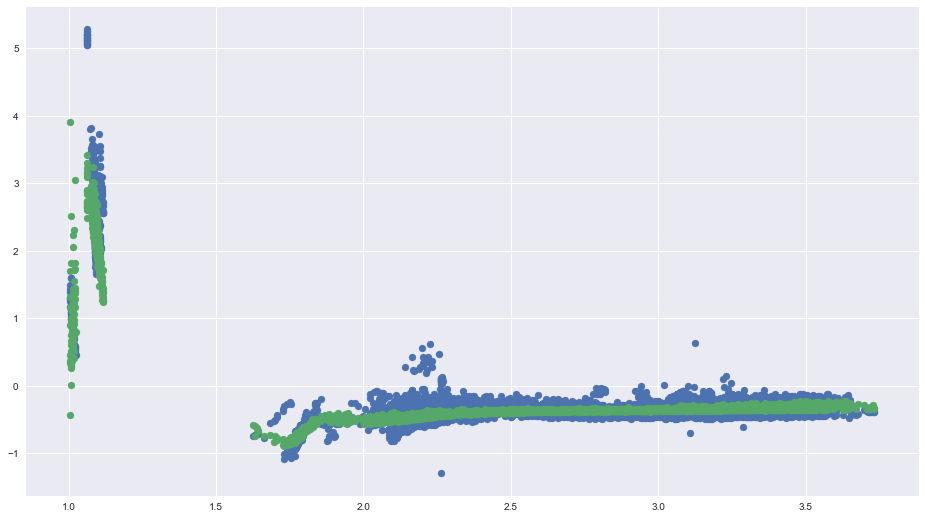

In [186]:
# plt.scatter(train_ds['x_0'],train_labels)
plt.scatter( unnorm_value(test_ds['displacement'], 'displacement'),test_labels)
plt.scatter( unnorm_value(test_ds['displacement'], 'displacement'),example_result)
plt.show()

In [187]:
test_types = []
for typ in bond_types:
    test_types.append(test_ds[test_ds[typ] == 1])

In [236]:
nn_score = 0
for typ in bond_types:
    # get test data of just this bond type
    type_test_ds = test_ds[test_ds[typ] == 1]
    
    # predict for this type
    type_predict = model.predict(np.array(type_test_ds))
    
    #unnorm predict and test
    unnorm_predict = unnorm_value(type_predict, 'scalar_coupling_constant').reshape(1,-1)[0]
    unnorm_test = unnorm_value(test_labels_data[type_test_ds.index].values, 'scalar_coupling_constant')
    
    # Score
    nn_score = score_type( unnorm_test, unnorm_predict ) 
    
    print( "Type ",typ, " has score ",nn_score )
    
#     plt.scatter(typ['displacement'],test_labels_data[typ.index].values)
#     plt.scatter(typ['displacement'],type_predict)

Type  1JHC  has score  0.6824328893776801
Type  2JHH  has score  0.6529339730846022
Type  1JHN  has score  0.7435838198316038
Type  2JHN  has score  0.6644950559436973
Type  2JHC  has score  0.6562008452702282
Type  3JHH  has score  0.6681338323155641
Type  3JHC  has score  0.6728775059609474
Type  3JHN  has score  0.7117473581830551


In [ ]:
# plt.scatter(train_ds['x_0'],train_labels)
plt.scatter(test_ds['displacement'],test_labels)
plt.scatter(test_ds['displacement'],example_result)
plt.show()

# Potential Map

The goal here is to craete a 2D potential map. This image will act as a form of image of the potential around the molecule.

I anticipate trying with low resolution initially, and training a NN on the image to try and estimate the scalar coupling value.

In [247]:
struct_df.iloc[0]

molecule_name    dsgdb9nsd_000001
atom_index                      0
atom                            C
x                      -0.0126981
y                          1.0858
z                        0.008001
Name: 0, dtype: object

In [65]:
print(struct_df[['x','y','z']].max())
print(struct_df[['x','y','z']].min())

x     9.382240
y    10.181957
z     7.894733
dtype: float64
x   -9.234889
y   -9.933938
z   -9.134765
dtype: float64


In [66]:
# struct_df = struct_df.set_index(['molecule_name','atom_index'])

In [533]:
def calc_pot( coord, atom ):
    disp = calc_pot_disp( coord, atom  )
    return potential( disp, typ )
    
# calculcates displacement on a passed row
def calc_pot_disp( c, a ):
    return np.linalg.norm(np.array([a.x-c[0],a.y-c[1],a.z-c[2]]))
    
def get_mol_atoms( mol_name ):
    return struct_df.loc[ struct_df.molecule_name == mol_name ]

In [478]:
def potential(r, atm):
    a = 1
    b = 1
    mult = 1
    if atm != 'H':
        mult = 10
    return mult * 4 *((a/r)**12 - (b/r)**6)
    

In [483]:
# struct_df.iloc[:1].apply(test_func, axis=0)

all_mols = struct_df[:10].molecule_name.unique()

# loop through all mols, for each, create potential map for all rows of that mol


res = 22
all_maps = {}

for mol in all_mols:
    
    
    # define space params / resolution / ticks
    x_min = y_min = -11
    x_max = y_max = 11
    x_size = x_max - x_min
    y_size = y_max - y_min
    x_ticks = x_size/res
    y_ticks = y_size/res
    
    # empty matrix
    pot_map = np.zeros( (x_size, y_size) )
    
    # get all atoms in mol
    atoms = get_mol_atoms( mol )
    
    # loop through space
    for x in np.arange(x_min, x_max, x_ticks):
        
        for y in np.arange(y_min, y_max, y_ticks):
            
            
            # calculate potential at x,y from all atoms
            for i,atom in atoms.iterrows():
                pot_map[ int(x+11) ][ int(y+11) ] = calc_pot( x,y, atom )
                
    
    # save map
    all_maps[mol] = pot_map


In [557]:
def normalize(ds):
    return (ds - ds.mean()) / ds.std()

In [828]:
# struct_df.iloc[:1].apply(test_func, axis=0)

all_mols = struct_df[:1000].molecule_name.unique()

# loop through all mols, for each, create potential map for all rows of that mol


res = 10
all_maps = {}

for mol in all_mols:
        
    # empty matrix
    pot_map = np.zeros( (res, res) )
    
    # get all atoms in mol
    atoms = get_mol_atoms( mol )
    

    # define space params
    x_min = atoms.x.min()
    x_max = atoms.x.max()
    y_min = atoms.y.min()
    y_max = atoms.y.max()
    z_min = atoms.z.min()
    z_max = atoms.z.max()
    
    x_width = (x_max - x_min) * 6
    y_width = (y_max - y_min) * 6
    z_width = (z_max - z_min) * 6 
    
    abs_z = 1/2*z_width - z_width/2
    
#     for z in np.arange(3):
#         abs_z = z/3*z_width - z_width/2
    
    # loop through space
    for x in np.arange(res):
        abs_x = x/res*x_width - x_width/2

        for y in np.arange(res):
            abs_y = y/res*y_width - y_width/2

            # calculate potential at x,y from all atoms
            for i,atom in atoms.iterrows():
                pot = calc_pot( (abs_x,abs_y,abs_z), atom )
                pot_map[ x ][ y ] = pot
    
    # save map
    all_maps[mol] = pot_map


Here I am checking to see if it seems reasonable the 2D potential slice / mapping has distinct features according to copupling constants. Who knows if a NN can pick on it.

In [829]:
all_mols

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000002', 'dsgdb9nsd_000003',
       'dsgdb9nsd_000004', 'dsgdb9nsd_000005', 'dsgdb9nsd_000006',
       'dsgdb9nsd_000007', 'dsgdb9nsd_000008', 'dsgdb9nsd_000009',
       'dsgdb9nsd_000010', 'dsgdb9nsd_000011', 'dsgdb9nsd_000012',
       'dsgdb9nsd_000013', 'dsgdb9nsd_000014', 'dsgdb9nsd_000015',
       'dsgdb9nsd_000016', 'dsgdb9nsd_000017', 'dsgdb9nsd_000018',
       'dsgdb9nsd_000019', 'dsgdb9nsd_000020', 'dsgdb9nsd_000021',
       'dsgdb9nsd_000022', 'dsgdb9nsd_000023', 'dsgdb9nsd_000024',
       'dsgdb9nsd_000026', 'dsgdb9nsd_000027', 'dsgdb9nsd_000028',
       'dsgdb9nsd_000029', 'dsgdb9nsd_000030', 'dsgdb9nsd_000031',
       'dsgdb9nsd_000032', 'dsgdb9nsd_000033', 'dsgdb9nsd_000034',
       'dsgdb9nsd_000035', 'dsgdb9nsd_000036', 'dsgdb9nsd_000037',
       'dsgdb9nsd_000038', 'dsgdb9nsd_000039', 'dsgdb9nsd_000040',
       'dsgdb9nsd_000041', 'dsgdb9nsd_000042', 'dsgdb9nsd_000043',
       'dsgdb9nsd_000044', 'dsgdb9nsd_000045', 'dsgdb9nsd_0000

In [808]:
bond_df[ bond_df.type == '1JHC'].head(20)

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,displacement,angle
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,-0.901529
1,1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.815896
2,2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946,0.814618
3,3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948,0.815563
17,17,17,dsgdb9nsd_000005,2,0,1JHC,171.2200,H,-0.027803,2.198949,0.014154,C,-0.013324,1.132466,0.008276,1.066598,0.999999
19,19,19,dsgdb9nsd_000006,2,0,1JHC,113.6120,H,0.914960,1.789511,0.003957,C,-0.013978,1.180211,0.007752,1.110939,0.884908
20,20,20,dsgdb9nsd_000006,3,0,1JHC,113.6130,H,-0.959110,1.764018,0.017183,C,-0.013978,1.180211,0.007752,1.110943,0.884140
21,21,21,dsgdb9nsd_000007,2,0,1JHC,83.5429,H,0.994873,1.939743,0.002941,C,-0.018704,1.525582,0.010433,1.094954,0.884119
22,22,28,dsgdb9nsd_000007,3,0,1JHC,83.5417,H,-0.542076,1.923611,-0.865117,C,-0.018704,1.525582,0.010433,1.094958,0.883554
23,23,34,dsgdb9nsd_000007,4,0,1JHC,83.5484,H,-0.525241,1.914173,0.900024,C,-0.018704,1.525582,0.010433,1.094968,0.883976


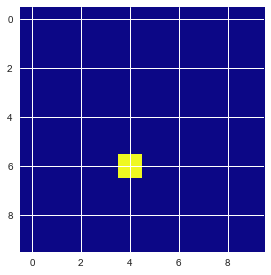

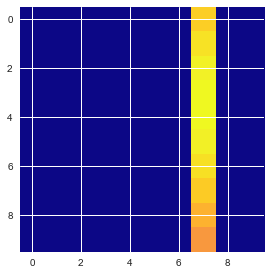

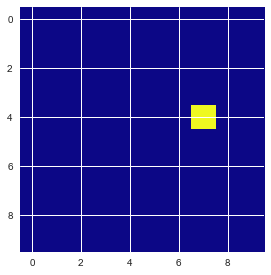

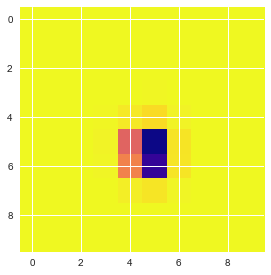

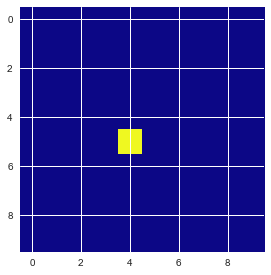

In [842]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = [8,4.5]
plt.rcParams.update({'font.size': 16})

plt.imshow( all_maps['dsgdb9nsd_000077'], cmap='plasma')
plt.show()
plt.imshow( all_maps['dsgdb9nsd_000005'], cmap='plasma')
plt.show()
plt.imshow( all_maps['dsgdb9nsd_000006'], cmap='plasma')
plt.show()
plt.imshow( all_maps['dsgdb9nsd_000007'], cmap='plasma')
plt.show()
plt.imshow( all_maps['dsgdb9nsd_000009'], cmap='plasma')
plt.show()

In [860]:
pd.DataFrame.from_dict(all_maps, np.arange( all_maps ))

TypeError: unsupported operand type(s) for -: 'dict' and 'int'

In [862]:
all_maps.keys()

dict_keys(['dsgdb9nsd_000001', 'dsgdb9nsd_000002', 'dsgdb9nsd_000003', 'dsgdb9nsd_000004', 'dsgdb9nsd_000005', 'dsgdb9nsd_000006', 'dsgdb9nsd_000007', 'dsgdb9nsd_000008', 'dsgdb9nsd_000009', 'dsgdb9nsd_000010', 'dsgdb9nsd_000011', 'dsgdb9nsd_000012', 'dsgdb9nsd_000013', 'dsgdb9nsd_000014', 'dsgdb9nsd_000015', 'dsgdb9nsd_000016', 'dsgdb9nsd_000017', 'dsgdb9nsd_000018', 'dsgdb9nsd_000019', 'dsgdb9nsd_000020', 'dsgdb9nsd_000021', 'dsgdb9nsd_000022', 'dsgdb9nsd_000023', 'dsgdb9nsd_000024', 'dsgdb9nsd_000026', 'dsgdb9nsd_000027', 'dsgdb9nsd_000028', 'dsgdb9nsd_000029', 'dsgdb9nsd_000030', 'dsgdb9nsd_000031', 'dsgdb9nsd_000032', 'dsgdb9nsd_000033', 'dsgdb9nsd_000034', 'dsgdb9nsd_000035', 'dsgdb9nsd_000036', 'dsgdb9nsd_000037', 'dsgdb9nsd_000038', 'dsgdb9nsd_000039', 'dsgdb9nsd_000040', 'dsgdb9nsd_000041', 'dsgdb9nsd_000042', 'dsgdb9nsd_000043', 'dsgdb9nsd_000044', 'dsgdb9nsd_000045', 'dsgdb9nsd_000046', 'dsgdb9nsd_000047', 'dsgdb9nsd_000048', 'dsgdb9nsd_000049', 'dsgdb9nsd_000050', 'dsgdb9ns

In [817]:
# cb = plt.colorbar()
# cb.set_label('Strength of Potential')


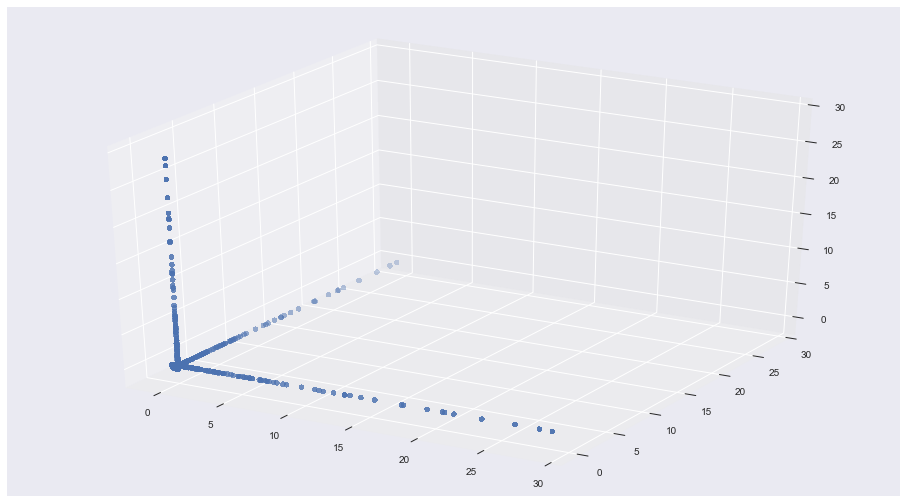

In [682]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = fig.gca(projection='3d')

data = normalize(all_maps['dsgdb9nsd_000001'])
xs = data[]
ys = data.transpose((1,2,0)).ravel()
zs = data.transpose((2,0,1)).ravel()

ax.scatter(xs,ys,zs, cmap='hot',
                       linewidth=0, antialiased=False)